In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
try:
    reload(galpy.df_src.streampepperdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamgapdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamdf)
except NameError:
    import galpy.df_src.streampepperdf
import numpy
from scipy import signal, ndimage
import statsmodels.api as sm
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_coords
from galpy.util import bovy_plot
%pylab inline
import seaborn as sns
R0, V0= 8., 220.
def rs(GM):
    """Give scale radius for a given mass"""
    return (GM/10.**-3.*bovy_conversion.mass_in_1010msol(V0,R0))**0.4*0.25/R0

Populating the interactive namespace from numpy and matplotlib


# Faster computations for low-mass impacts

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1]),prog_init.y(times[-1]),prog_init.z(times[-1]),
              prog_init.vx(times[-1]),prog_init.vy(times[-1]),prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [4]:
sdf_pepper= galpy.df_src.streampepperdf.streampepperdf(\
    sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
    leading=False,nTrackChunks=26,nTrackIterations=1,
    sigMeanOffset=4.5,
    tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
    Vnorm=V0,Rnorm=R0,
    timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),2.88/bovy_conversion.time_in_Gyr(V0,R0)],
    spline_order=1)

In [5]:
# Simulate
sdf_pepper.simulate(rate=2.,
                    sample_GM=lambda: 10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                    sample_rs=rs)

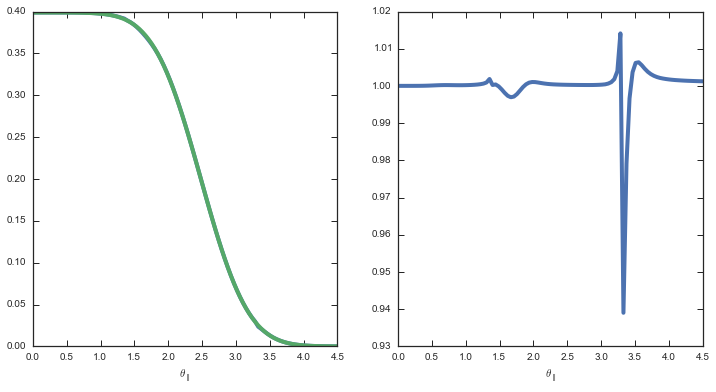

In [6]:
xs= numpy.linspace(0.,4.5,101)
# Compute
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper)._density_par(x) for x in xs])
dens_full= numpy.array([sdf_pepper.density_par(x,approx=True) for x in xs])
figsize(12,6)
subplot(1,2,1)
plot(xs,dens_full/numpy.sum(dens_full)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens_full/numpy.sum(dens_full))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

In [7]:
sdf_pepper.approx_kicks(0.05,relative=True)
#sdf_pepper.approx_kicks(0.006/1000.,relative=False)
print len(sdf_pepper._sgapdfs_uniq[0]._kick_interpdOpar_poly.c[-1])

285


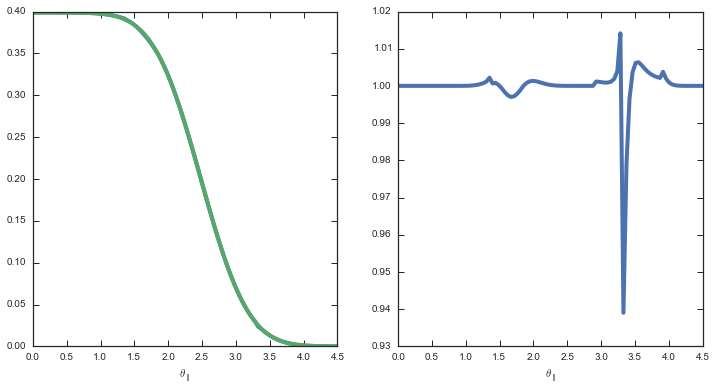

In [8]:
xs= numpy.linspace(0.,4.5,101)
# Compute
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper)._density_par(x) for x in xs])
dens= numpy.array([sdf_pepper.density_par(x,approx=True) for x in xs])
figsize(12,6)
subplot(1,2,1)
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens/numpy.sum(dens))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

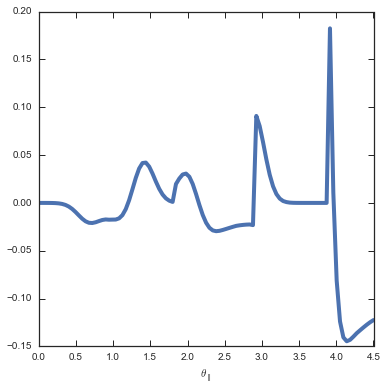

In [9]:
figsize(6,6)
plot(xs,(dens-dens_full)/dens_full*100,lw=4.)
xlabel(r'$\theta_\parallel$')

## Does pickling work?

In [10]:
sdf_pepper_pickle= galpy.df_src.streampepperdf.streampepperdf(\
    sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
    leading=False,nTrackChunks=26,nTrackIterations=1,
    sigMeanOffset=4.5,
    tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
    Vnorm=V0,Rnorm=R0,
    timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),1.88/bovy_conversion.time_in_Gyr(V0,R0)],
    spline_order=1)

In [11]:
from galpy.util import save_pickles
save_pickles('test.pkl',sdf_pepper_pickle)